# Correlation analysis for IFN-B response

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap

In [21]:
%matplotlib inline

In [22]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [23]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [24]:
import warnings
# warnings.filterwarnings('ignore')

In [25]:
from sklearn.decomposition import PCA

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/schypo-0.0.0-py3.7.egg')
import schypo

In [28]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [29]:
tf = 'STAT1'

### Load the data

In [30]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [31]:
def simplify_name(name):
    return name.split('.')[0]

In [32]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


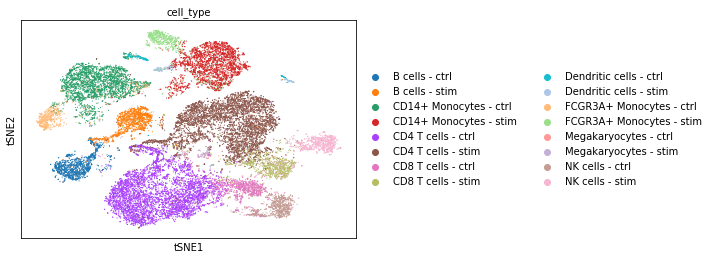

In [33]:
sc.pl.tsne(adata, color='cell_type')

In [34]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [35]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [36]:
# with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
# 	tfs = pkl.load(f)

In [37]:
# tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
# tfs = tf_df['GeneSym'].tolist()

In [38]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### STAT1/STAT2 correlations

In [434]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()

schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.05, 
    min_perc_group=0.85)

target_genes = adata_ct.var.index.tolist()
filtered_tfs = list(set(target_genes) & set(tfs))

schypo.compute_2d_moments(
    adata_ct, 
    ['STAT1'], 
    target_genes)

In [435]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0
        
    if 'ctrl' in group:
        ctrl_mean_corr += temp
        ctrl_count += ~np.isnan(temp)
        
    if 'stim' in group:
        stim_mean_corr += temp
        stim_count += ~np.isnan(temp)

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [436]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()

In [437]:
ctrl_df = pd.DataFrame()
ctrl_df['gene'] = target_genes
ctrl_df['corr'] = ctrl_mean_corr.ravel()
ctrl_df['stim'] = 'ctrl'
ctrl_df['isgf3'] = ctrl_df['gene'].apply(lambda x: x in isgf3_genes)

stim_df = pd.DataFrame()
stim_df['gene'] = target_genes
stim_df['corr'] = stim_mean_corr.ravel()
stim_df['stim'] = 'stim'
stim_df['isgf3'] = stim_df['gene'].apply(lambda x: x in isgf3_genes)

df = pd.concat([ctrl_df, stim_df])
# df['corr']  = df['corr'].abs()

In [438]:
stats.mannwhitneyu(stim_df.query('isgf3')['corr'], stim_df.query('~isgf3')['corr'])

MannwhitneyuResult(statistic=126951.0, pvalue=0.012980315402637985)

In [439]:
stats.mannwhitneyu(ctrl_df.query('isgf3')['corr'], ctrl_df.query('~isgf3')['corr'])

MannwhitneyuResult(statistic=115910.0, pvalue=4.406069166375581e-05)

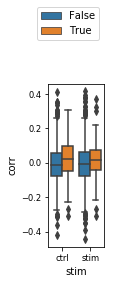

In [440]:
plt.figure(figsize=(1, 3))
sns.boxplot(x='stim', y='corr', hue='isgf3', data=df)
plt.legend(bbox_to_anchor=(0, 0, 1, 1.5))